# First break picking using semantic segmentation approach 

In this notebook, we will continue to discuss first break picking task, but now we will try to treat this task as semantic segmentation. In this case, the neural network predicts a binary mask where each sample of a trace before the first break is labeled as the no-signal one while all the samples after the first break — as signal ones.

* [Dataset](#Dataset)
* [Model architecture](#Model-Architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Running time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Conclusion](#Conclusion)

In [1]:
def plot_loss(loss):
    plt.figure(figsize=(25, 6))
    plt.grid()
    plt.plot(loss)
    plt.title('Loss history during training', fontsize=16)
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel('Mean Absolute Error', fontsize=16)
    plt.show()

Define all necessery imports

In [2]:
import sys
sys.path.append('../../../')

import numpy as np
import matplotlib.pyplot as plt

from SeismicPro.seismicpro.src import SeismicDataset, Survey, MetricMap
from SeismicPro.seismicpro.batchflow import B, V, F, L, Pipeline
from SeismicPro.seismicpro.src.gather.utils import convert_mask_to_pick
from batchflow.models.torch import TorchModel
from SeismicPro.seismicpro.batchflow.models.torch import UNet, ResBlock

import warnings
warnings.filterwarnings("ignore")

%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


## Dataset

Initialize surveys and load first breaks

In [3]:
sgy_path = '../processing_/data/test_g_coord.sgy'
picking_path = "../processing_/data/VAY22_picking"

survey = Survey(sgy_path, header_index='FieldRecord', header_cols=['TraceNumber', 'offset'], name='raw')
survey.load_first_breaks(picking_path, inplace=True)

Trace headers loaded:   0%|          | 0/58706100 [00:00<?, ?it/s]

Define dataset and split the data into train and test sets

In [4]:
dataset = SeismicDataset(survey)
dataset.split(shuffle=True)

Reindex dataset by individual traces

In [5]:
dataset = dataset.reindex('TRACE_SEQUENCE_FILE')

In [6]:
dataset.test.size, dataset.train.size

(16854, 66713)

## Model Architecture
Specify model config, optimizer and loss function. We use UNet-based architecture consisting of two parts - encoder and decoder. Both of them are based on ResNet-like models with Concurrent Spatial and Channel Squeeze & Excitation attention blocks.

In [7]:
BATCH_SIZE = 512
N_EPOCHS = 5

model_config = {
    'inputs_shapes': (1, 800),
    
    'order': ['encoder', 'embedding', 'decoder', 'head'],
    

    'encoder': { 'type': 'encoder',
                 'order': ['block', 'skip', 'downsample'],
                 'num_stages': 4,
                 'blocks': { 'layout': 'cna cna',
                             'kernel_size': 5,
                             'padding': 'same',
                             'stride': 1,
                             'channels': [8, 16, 32, 64],
                             'bias': False
                            },
                'downsample': {'layout': 'p',
                               'kernel_size': 2,
                               'stride': 2,
                               'channels': 'same * 2'
                              } 
               },
    'embedding': {
                'input_type': 'list',
                'input_idx': -1,
                'output_type': 'list',
                'layout': 'cna cna',
                'kernel_size': 3,
                'padding': 'same',
                'channels': 128,
            },
    
    'decoder': {
        'skip': True,
        'indices':  [3, 2, 1, 0],
        'type': 'decoder',
        'num_stages': 4,
        'order': ['upsample', 'combine', 'block'],
        'blocks': {'layout': 'cna cna', 
                   'channels': [64, 32, 16, 8],
                   'kernel_size': 5, 
                   'stride': 1,
                   'padding': 'same',
                   'bias': False
                  },
        'combine': {'op': 'concat', 'force_resize': False}, 
        'upsample': {'layout': 't', 'kernel_size': 2, 'stride': 2, 'channels': 'same // 2', 'bias': True} # kernel_size = 3 (checkboards)
    },
    'head': {
        'layout': 'c', 'channels': 1,
        'classes': 2
    },
    
    'loss': 'bdice', 
    'device': 'gpu:0',
    'optimizer': {'name': 'Adam', 'lr': 1e-3},
    'output': 'sigmoid',
    'model_class': TorchModel
}

batchflow_model = TorchModel(model_config)
batchflow_model.repr(2)

Network(
    (encoder): EncoderModule(
        (block-0:       (?,   1, 800)  ⟶ (?,   8, 800))
        (skip-0:        (?,   8, 800)  ⟶ (?,   8, 800))
        (downsample-0:  (?,   8, 800)  ⟶ (?,   8, 400))
        (block-1:       (?,   8, 400)  ⟶ (?,  16, 400))
        (skip-1:        (?,  16, 400)  ⟶ (?,  16, 400))
        (downsample-1:  (?,  16, 400)  ⟶ (?,  16, 200))
        (block-2:       (?,  16, 200)  ⟶ (?,  32, 200))
        (skip-2:        (?,  32, 200)  ⟶ (?,  32, 200))
        (downsample-2:  (?,  32, 200)  ⟶ (?,  32, 100))
        (block-3:       (?,  32, 100)  ⟶ (?,  64, 100))
        (skip-3:        (?,  64, 100)  ⟶ (?,  64, 100))
        (downsample-3:  (?,  64, 100)  ⟶ (?,  64,  50))
    )
    (embedding: [(?,   8, 800),
                 (?,  16, 400),
                 (?,  32, 200),
                 (?,  64, 100),
                 (?,  64,  50)] ⟶ [(?,   8, 800),
                                    (?,  16, 400),
                                    (?,  32, 200),
   

In [8]:
def crop_gathers(gathers, time):
    for gather in gathers:
        gather.data = gather.data[:, :time]
    return gathers

## Training
Define training pipeline that contains all procedures from data loading to model training. This pipeline runs for 5 epochs.

In [9]:
train_template = (Pipeline()
    # initializing the model and auxiliary variable
    .add_namespace(np)
    .init_variable('loss_history', [])
    .init_model('fbp_model', config=model_config)
    .init_variable('predicted_times')
    .init_variable('mae', [])
        
    # data preprocessing
    .load(src='raw', combined=True)
    .crop_gathers(gathers=L('raw'), time=800)
    .scale_standard(src='raw')
    .make_model_inputs(src=L('raw').data, dst='inputs', expand_dims_axis=1)

    # mask preprocessing
    .pick_to_mask(src='raw', first_breaks_col='FirstBreak')
    .crop_gathers(gathers=L('raw'), time=800)
    .make_model_inputs(src=L('raw').data, dst='prepared_mask', expand_dims_axis=1)
    
    # prediction
    .predict_model('fbp_model', inputs=L('inputs'), outputs='sigmoid', save_to=L('predicted_masks'))
    # result prostprocessing
    .convert_mask_to_pick(mask=L('predicted_masks').squeeze(), samples=np.arange(0, 1600, 2), threshold=0.5, save_to=V('predicted_times', mode='w'))
                  
    # collecting metric
    .mean(abs(V('predicted_times') - B('raw')[0]['FirstBreak'].squeeze()), save_to=V('mae', mode='a'))
                  
    # model training and loss accumulating
    .train_model('fbp_model', outputs='loss', inputs=L('inputs'),
                 targets=L('prepared_mask'), save_to=V('loss_history', mode='a'))
    )

train_pipeline = train_template << dataset.train
train_pipeline.run(BATCH_SIZE, n_epoch=5, drop_last=True, shuffle=True, bar='n')

  0%|                                                                                                         …

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


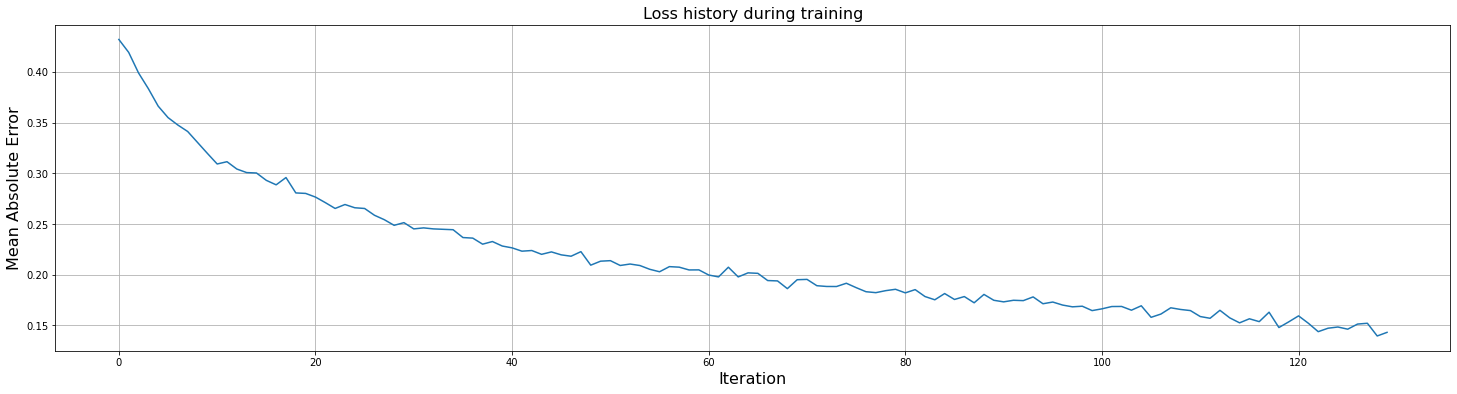

In [10]:
plot_loss(train_pipeline.v('loss_history'))

In [11]:
print(f"Mean absolute error is {train_pipeline.v('mae')[-1]:.2f} samples")

Mean absolute error is 12.78 samples


## Inference

Measure model's quality as a module of the distance between predicted and real times of first break. To convert binary mask to picking we use ```mask_to_pick``` method that defines the first break as the beginning of the longest sequence of signal samples in a mask.

In [12]:
val_template = (Pipeline()
    # initializing the model and auxiliary variable
    .add_namespace(np)
    .import_model('fbp_model', source=train_pipeline)
    .init_variable('predicted_times')
    .init_variable('mae', [])
    
    # loading and data preparation
    .load(src='raw', combined=True)
    .crop_gathers(gathers=L('raw'), time=800)
    .scale_standard(src='raw')
    .make_model_inputs(src=L('raw').data, dst='inputs', expand_dims_axis=1)
    # model prediction
    .predict_model('fbp_model', inputs=L('inputs'), outputs='sigmoid', save_to=L('predicted_masks'))
    
    # result prostprocessing
    .convert_mask_to_pick(L('predicted_masks').squeeze(), samples=np.arange(0, 1600, 2), threshold=0.5, save_to=V('predicted_times', mode='w'))
    .mean(abs(V('predicted_times') - B('raw')[0]['FirstBreak'].squeeze()), save_to=V('mae', mode='a'))
)

val_pipeline = val_template << dataset.test
val_pipeline.run(BATCH_SIZE, n_iters=100, drop_last=True, shuffle=False, bar='n')

  0%|                                                                                                         …

In [13]:
print(f"Mean absolute error is {np.mean(val_pipeline.v('mae')):.2f} samples")

Mean absolute error is 10.78 samples


## Model evaluation
Let's visualize the predictions of the model. Firstly, reindex the dataset by FieldRecord, in order to make predictions for gathers, not for traces.

In [14]:
dataset_inference = dataset.test.copy()

In [15]:
dataset_inference.index.reindex('FieldRecord', inplace=True)

In [16]:
def save_predicted_breaks(survey, times):
    for i, fb in enumerate(times):
        survey[i]["PredictedBreak"] = fb

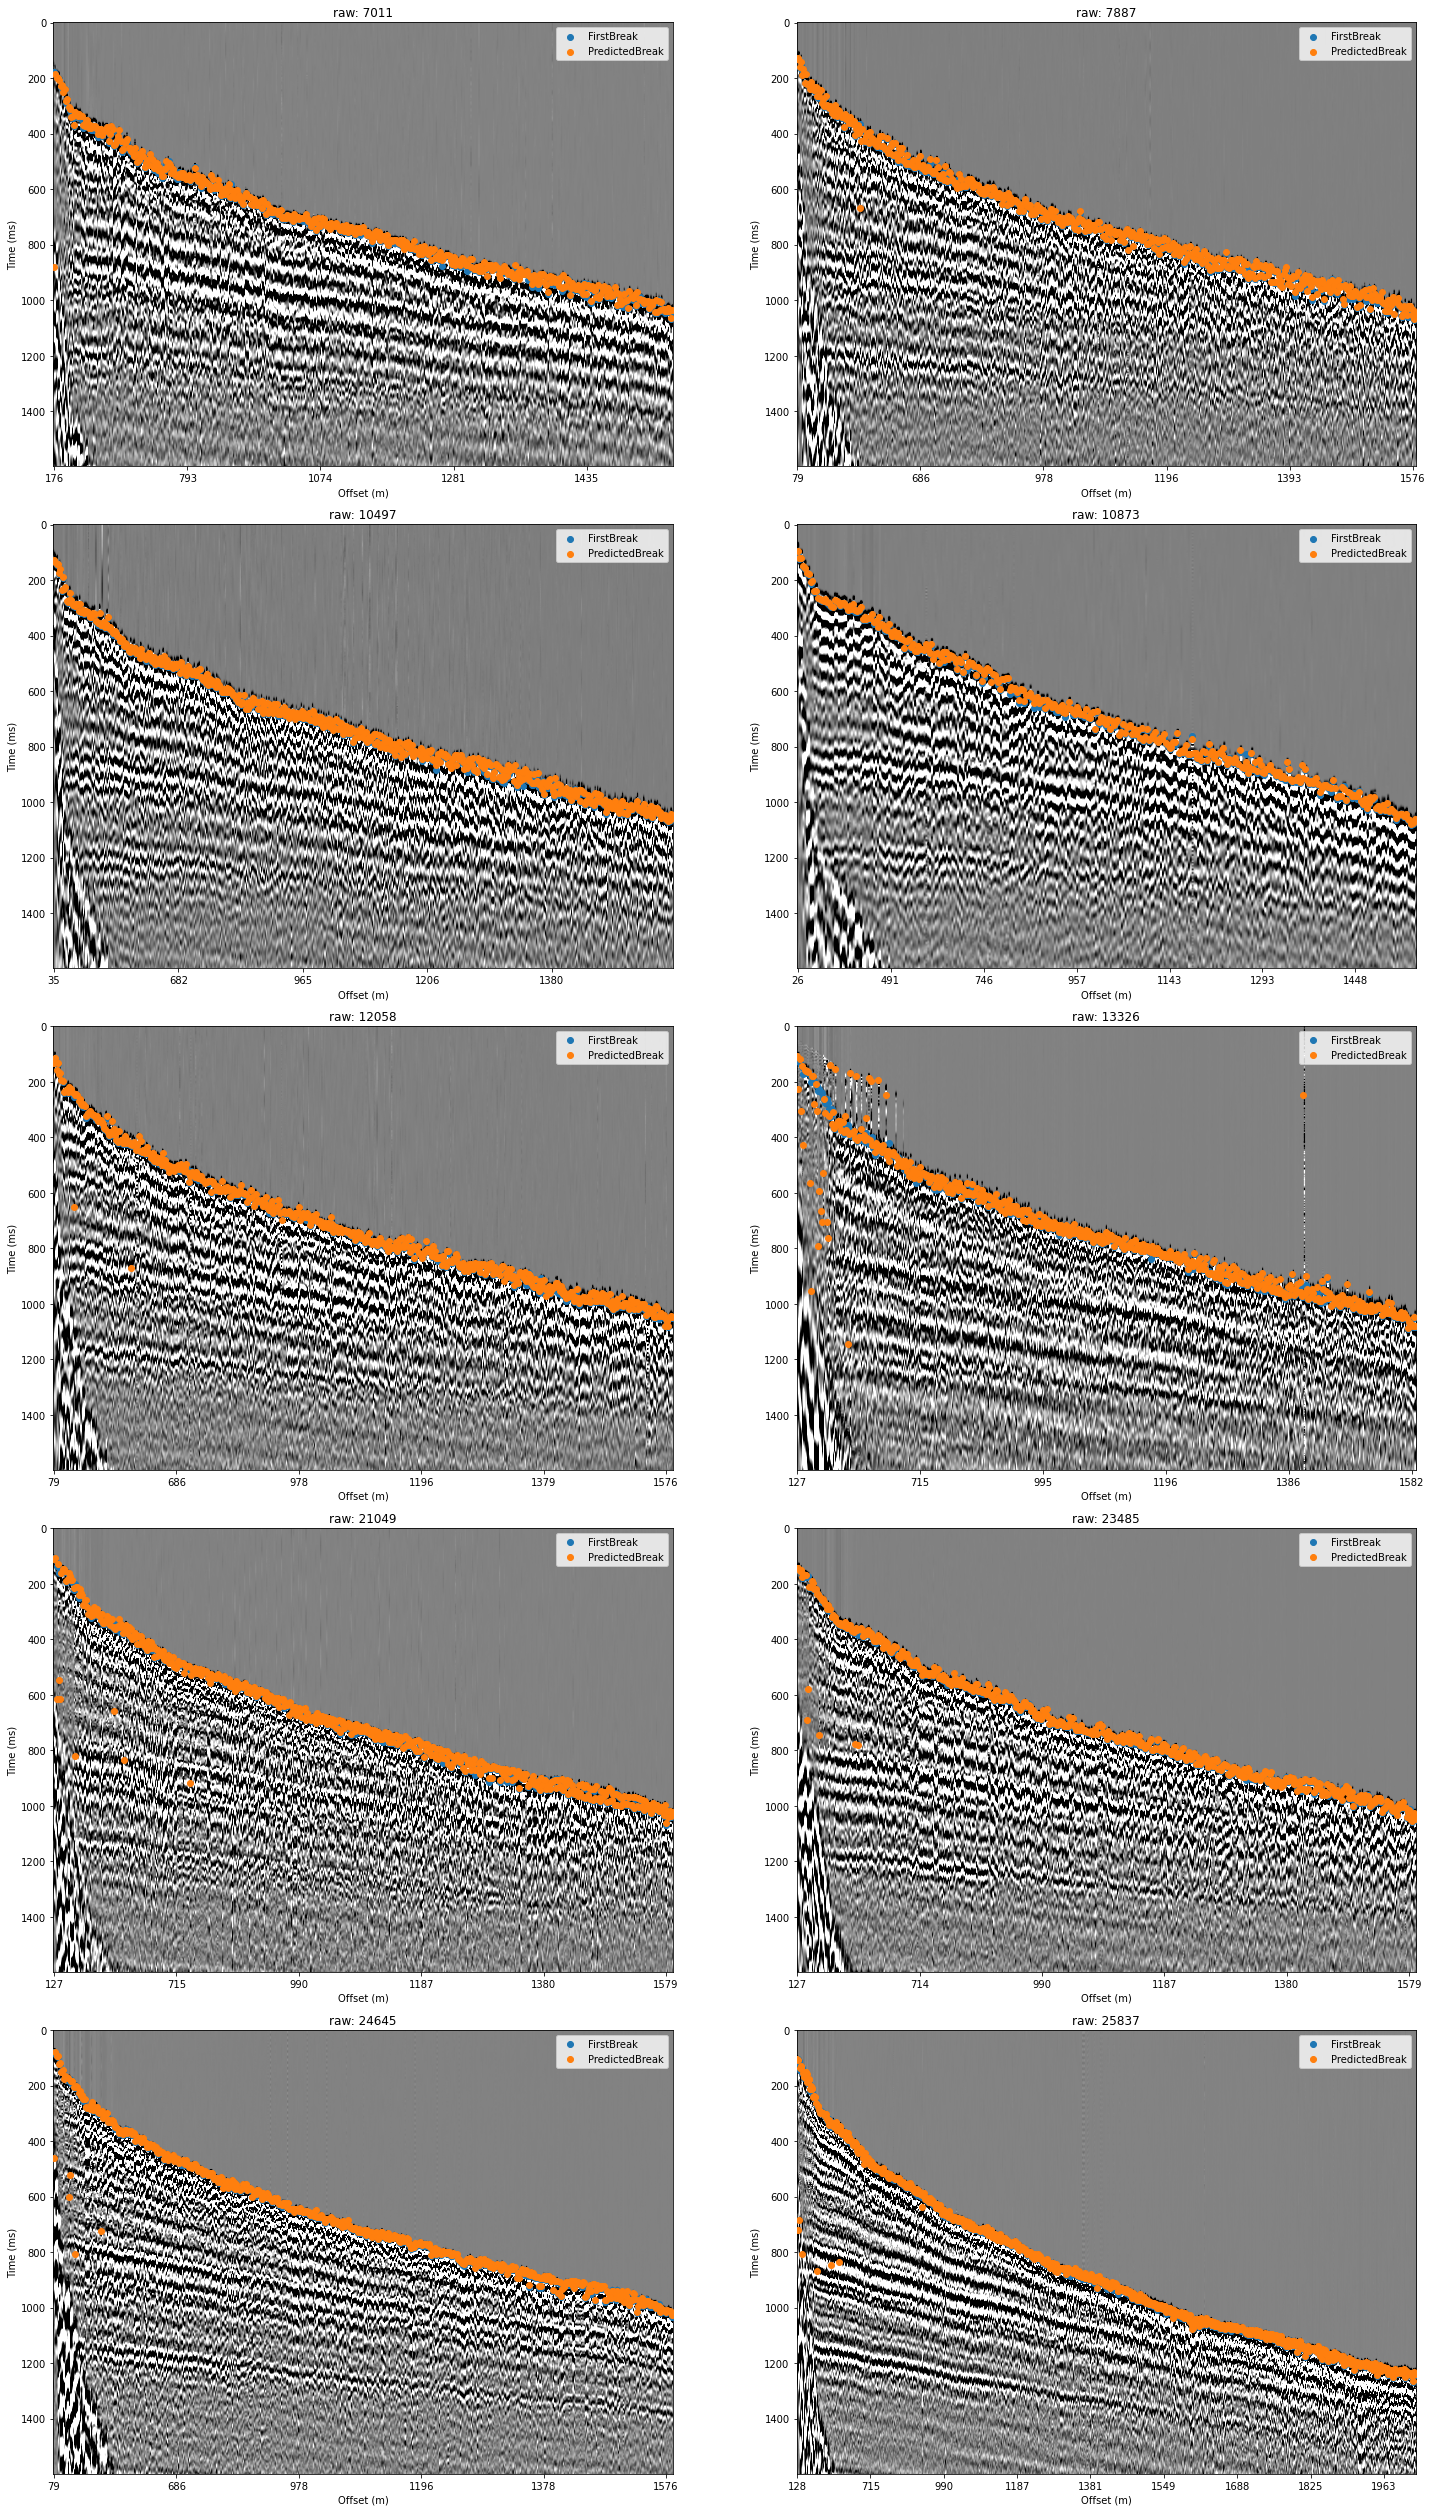

In [17]:
plot_pipeline_template = (Pipeline()
    .import_model('fbp_model', train_pipeline)
    .init_variable('predicted_times')
    .init_variable('PredictedBreak')
                          
    # loading and data preparation
    .load(src='raw')
    .crop_gathers(gathers=L('raw'), time=800)
    .scale_standard(src='raw')
    .make_model_inputs(src=L('raw').data, dst='inputs', expand_dims_axis=1)
                          
    .predict_model('fbp_model', inputs=B('inputs'), outputs='sigmoid', save_to=L('predicted_masks'))

    # result prostprocessing
    .convert_mask_to_pick(mask=L('predicted_masks').squeeze(), samples=np.arange(0, 1600, 2), threshold=0.5, save_to=V('predicted_times'))
    .split_model_outputs(src=V('predicted_times'), dst=V('PredictedBreak'), shapes=L('raw').shape[0])
    .save_predicted_breaks(survey=L('raw'), times=V('PredictedBreak'))
    .sort(src='raw', by='offset')
    .plot(src='raw', event_headers=['FirstBreak', 'PredictedBreak'])
    )

plot_pipeline = plot_pipeline_template << dataset_inference
batch = plot_pipeline.next_batch(batch_size=10)